# data cleaning

In [1]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer,  TfidfTransformer
import jieba
from pycantonese.word_segmentation import Segmenter
import pycantonese
import pandas as pd
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pickle
import re

import warnings
warnings.filterwarnings('ignore')

In [38]:
df_msg_valid = pd.read_excel('../data/good_bad_chat_history_total_20240117.xlsx')

In [39]:
df_pp_count = df_msg_valid.drop_duplicates(subset=['conversationId'])[['conversationId', 'max_pp']]
df_pp_count_des = df_pp_count.describe()

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['Microsoft JhengHei']

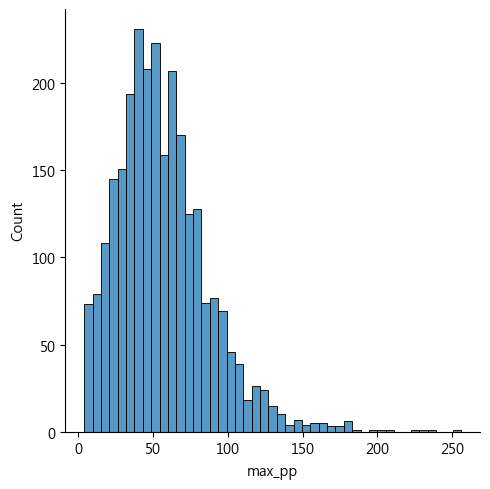

In [41]:
sns.displot(df_pp_count, x='max_pp')

In [42]:
# calculate Interquantile Range
print(df_pp_count_des.loc['75%','max_pp']+1.5*(df_pp_count_des.loc['75%','max_pp']-df_pp_count_des.loc['25%','max_pp']))

131.5


In [43]:
#select sessions with message count larger than 4 to ensure data balance
valid_convId_pp = df_pp_count[(df_pp_count['max_pp']>=4)&(df_pp_count['max_pp']<=132)]['conversationId'].tolist()
len(valid_convId_pp)

2589

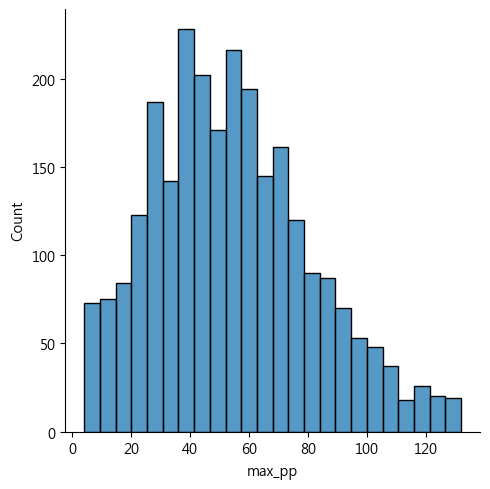

In [44]:
# draw distribution of total message exchange count after removing outliers
df_pp = df_msg_valid[(df_msg_valid['conversationId'].isin(valid_convId_pp))].drop_duplicates(subset=['conversationId'])
sns.displot(df_pp, x='max_pp')

In [45]:
df_msg_validd = df_msg_valid[(df_msg_valid['conversationId'].isin(valid_convId_pp))]
df_msg_validd.reset_index(inplace=True, drop=True)

In [46]:
good_bad_count = df_msg_validd.drop_duplicates(subset=['conversationId'])
good_bad_count['quality'].value_counts()

good    1993
bad      596
Name: quality, dtype: int64

# data processing

In [11]:
df_msg_valid = df_msg_validd.copy()

In [12]:
df_msg_valid = df_msg_valid[(df_msg_valid['conversationId'].isin(good_bad_count[(good_bad_count['quality'] == 'bad')]['conversationId'].tolist()))]
df_msg_valid.reset_index(inplace=True, drop=True)

In [13]:
df_msg_valid['msg_token_list'] = None
for i in range(len(df_msg_valid['msg_token'])):
    df_msg_valid['msg_token_list'][i] = df_msg_valid['msg_token'][i].split(' ')

In [14]:
df_msg_valid=df_msg_valid.assign(pp_percentage=df_msg_valid['pp']/df_msg_valid['max_pp'])

In [16]:
# split session into equal fifth
def df_label_category(df, cat):
    labels = np.arange(len(cat)-1)
    category = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
    df['pp_category'] = pd.cut(df['pp_percentage'], labels=labels, bins=category, include_lowest=True)
    return df

n_stage=6
df_msg_valid=df_msg_valid.pipe(df_label_category, np.linspace(0, 1 , n_stage) )

In [17]:
df_msg_valid = df_msg_valid[['conversationId', 'from_whom', 'datetime', 'msg_replace', 'msg_token', 'msg_token_list', 'pp', 'max_pp', 'pp_percentage', 'pp_category']]

In [18]:
for i in range(len(df_msg_valid['msg_token_list'])):
    if df_msg_valid['from_whom'][i] == True:
        for j in range(len(df_msg_valid['msg_token_list'][i])):
            df_msg_valid['msg_token_list'][i][j] = 'H' + df_msg_valid['msg_token_list'][i][j]
    else:
        for j in range(len(df_msg_valid['msg_token_list'][i])):
            df_msg_valid['msg_token_list'][i][j] = 'C' + df_msg_valid['msg_token_list'][i][j]

In [19]:
df_msg_valid['msg_token'] = [' '.join(i) for i in df_msg_valid['msg_token_list']]

In [20]:
df_msg_valid['pp_category'] = df_msg_valid['pp_category'].fillna(0)

# hmm training

## message-based tf-idf

In [21]:
# Instantiate TfidfVectorizer with custom stopwords
tfidf_vectorizer = TfidfVectorizer(token_pattern='\\b\\w+\\b', min_df=2)  # min_df to avoid very rare words , stop_words = list(low_freq_words)

# Fit and transform the data
tfidf_matrix = tfidf_vectorizer.fit_transform(df_msg_valid['msg_token'])

# Get feature names and their corresponding TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

# Create a DataFrame for TF-IDF scores
tfidf_df = pd.DataFrame({'word': feature_names, 'score': tfidf_scores})

In [22]:
# Filter based on a score threshold (3rd quantile)
threshold = tfidf_df['score'].describe()['75%']

low_tfidf_words = list(tfidf_df.loc[tfidf_df['score']<threshold]['word'])

In [23]:
cv = CountVectorizer(min_df = 2, max_df = 1.0, token_pattern ='\\b\\w+\\b', stop_words = low_tfidf_words) # +list(low_freq_words)
cv.fit(df_msg_valid['msg_token'])
X = cv.transform(df_msg_valid['msg_token'])

In [24]:
X

<31777x1994 sparse matrix of type '<class 'numpy.int64'>'
	with 73022 stored elements in Compressed Sparse Row format>

## remove messages with no bags-of-words

In [25]:
## Remove conversation without any BoW inside
threshold = 1
X_final = X[np.where(X.sum(axis=1) > threshold)[0],:]
df_msg_valid_final = df_msg_valid.iloc[np.where(X.sum(axis=1) > threshold)[0],:]
df_msg_valid_final.reset_index(inplace = True, drop = True)

In [26]:
X_final

<17900x1994 sparse matrix of type '<class 'numpy.int64'>'
	with 62623 stored elements in Compressed Sparse Row format>

In [47]:
final_conv_msg_count = pd.DataFrame(df_msg_valid_final['conversationId'].value_counts())
final_conv_msg_count.reset_index(inplace=True,drop=False)

# prepare emission probability matrix

In [28]:
emission=pd.DataFrame(X_final.toarray())
df_msg_valid_final.pp_category=df_msg_valid_final.pp_category.astype(int)
emission["stage"]=df_msg_valid_final.pp_category

In [29]:
emission=emission.groupby('stage').sum()

In [30]:
emission+=1

In [31]:
emission

,0,1,2,3,4,5,6,7,8,9,...,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993
stage,,,,,,,,,,,,,,,,,,,,,
0,3,5,3,1,4,3,3,1,3,4,...,4,9,6,4,3,16,14,5,8,2
1,3,5,11,3,4,4,6,3,4,6,...,10,12,10,3,11,11,11,2,5,3
2,2,11,6,3,2,1,4,5,4,3,...,1,14,3,3,4,11,7,2,4,6
3,3,9,9,4,8,4,8,3,3,13,...,1,8,5,6,4,10,6,2,5,4
4,3,15,21,23,19,6,4,6,14,17,...,1,6,1,2,1,3,5,1,3,3


# training HMM

In [32]:
import hmmlearn as hmmlearn
from hmmlearn import hmm
from hmmlearn.base import ConvergenceMonitor

In [33]:
df_emission_scale=emission.apply(lambda x:x/emission.sum(axis=1),axis=0)

## 5 stage HMM
chmm=hmmlearn.hmm.PoissonHMM(n_components=5,params ='tl', init_params='', n_iter=1000, implementation ='log' ,transmat_prior=10, lambdas_prior=10)
chmm.startprob_=np.array([1, 0, 0, 0, 0])

chmm.transmat_ = np.array([[0.919, 0.023, 0.022, 0.022, 0.014],
                            [0.019, 0.4  , 0.029, 0.067, 0.485],
                            [0.002, 0.716, 0.012, 0.043, 0.227],
                            [0, 0.70, 0.007, 0.086, 0.207],
                            [0.   , 0.   , 0.   , 0.   , 1.   ]])

chmm.lambdas_=df_emission_scale

In [34]:
df_len=df_msg_valid_final.groupby("conversationId").count()['pp_category']

In [35]:
np.round(chmm.transmat_, 3)

array([[0.919, 0.023, 0.022, 0.022, 0.014],
       [0.019, 0.4  , 0.029, 0.067, 0.485],
       [0.002, 0.716, 0.012, 0.043, 0.227],
       [0.   , 0.7  , 0.007, 0.086, 0.207],
       [0.   , 0.   , 0.   , 0.   , 1.   ]])

In [303]:
chmm.fit(X_final.toarray(), df_len)

PoissonHMM(init_params='', lambdas_prior=10, n_components=5, n_iter=1000,
           params='tl', random_state=RandomState(MT19937) at 0x166B7B69940,
           transmat_prior=10)

In [304]:
chmm.monitor_

ConvergenceMonitor(
    history=[-467158.0621456213, -421468.7198040533, -412654.009695118, -407040.49886812194, -404604.937016444, -403532.5920139173, -402944.2015197065, -402553.28774570266, -402342.0365735363, -402198.40414685244, -402090.72358765214, -402026.16704162105, -401962.1991002474, -401900.0960402121, -401848.1287105764, -401793.2559318298, -401756.3510854977, -401721.52302148234, -401681.22224648553, -401624.61054555274, -401576.58236307837, -401520.0859118375, -401475.5023280467, -401448.45748818305, -401426.29253922653, -401405.41025829193, -401382.5706570659, -401362.94599531515, -401345.6820286008, -401333.08163226803, -401323.0644563154, -401315.1826495016, -401308.51917518245, -401302.37702803774, -401293.40014688927, -401278.54490671924, -401270.17511806986, -401263.7026806495, -401258.72863315174, -401254.1976680477, -401249.4014487096, -401245.0188072256, -401241.7331568342, -401239.1193462276, -401237.02400517446, -401235.2601934564, -401233.44389286806, -401231

In [36]:
boW_prob = pd.DataFrame(chmm.lambdas_, columns=cv.get_feature_names_out()).transpose()

In [37]:
boW_prob_baseline=pd.DataFrame(df_emission_scale.to_numpy(),columns=cv.get_feature_names_out()).transpose()

In [328]:
np.set_printoptions(suppress=True, precision=3)
np.round(chmm.transmat_, 3)

array([[0.214, 0.569, 0.153, 0.031, 0.033],
       [0.002, 0.49 , 0.436, 0.064, 0.008],
       [0.002, 0.524, 0.399, 0.037, 0.039],
       [0.   , 0.376, 0.085, 0.462, 0.077],
       [0.   , 0.   , 0.   , 0.   , 1.   ]])

# time allocation percentage

In [311]:
lengths = df_len.tolist()
chmm_pred_list = []

start = 0
for length in lengths:
    end = start + length
    subseq = X_final.toarray()[start:end]
    chmm_pred_list.append(chmm.predict(subseq, length))
    start = end
    
combined_pred_list = [item for sublist in chmm_pred_list for item in sublist]
df_msg_valid_final['pred_stage'] = combined_pred_list

In [313]:
# sort conversations by ID and time. Then calculate time duration between each message
df_msg_valid_final['time_diff'] = df_msg_valid_final.sort_values(by=['conversationId', 'datetime']).groupby('conversationId')['datetime'].diff().shift(-1)

# convert time duration to seconds
df_msg_valid_final['time_diff_seconds'] = df_msg_valid_final['time_diff'].dt.total_seconds()

# sum up time duration of each stage within each conversation
stage_durations = df_msg_valid_final.groupby(['conversationId', 'pred_stage'])['time_diff_seconds'].sum().reset_index()

# calculate total time duration of each conversation
total_durations = df_msg_valid_final.groupby('conversationId')['time_diff_seconds'].sum().reset_index()

# merge conversation total time duration to dataframe
stage_durations = stage_durations.merge(total_durations, on='conversationId')

# calculate percentage of each stage within each conversation
stage_durations['percentage'] = (stage_durations['time_diff_seconds_x'] / stage_durations['time_diff_seconds_y']) * 100

stage_durations

,conversationId,pred_stage,time_diff_seconds_x,time_diff_seconds_y,percentage
0,0042b140-0ffd-4d8f-aeed-b01a2a4ade01,0,502.172,1142.281,43.962212
1,0042b140-0ffd-4d8f-aeed-b01a2a4ade01,2,640.109,1142.281,56.037788
2,0042b140-0ffd-4d8f-aeed-b01a2a4ade01,4,0.000,1142.281,0.000000
3,00aba99a-3a7c-47e7-90c1-27340b3dcc14,0,141.160,5151.765,2.740032
4,00aba99a-3a7c-47e7-90c1-27340b3dcc14,1,2531.972,5151.765,49.147661
...,...,...,...,...,...
2418,ffb565f8-a619-41bd-9815-8503432c1e3e,3,0.022,6207.377,0.000354
2419,ffb565f8-a619-41bd-9815-8503432c1e3e,4,450.139,6207.377,7.251678
2420,ffe77bd6-a4ba-46f4-a1f0-f594d286cefc,0,773.360,1305.096,59.256944
2421,ffe77bd6-a4ba-46f4-a1f0-f594d286cefc,2,531.736,1305.096,40.743056


In [321]:
grouped = stage_durations.groupby(['pred_stage'])['percentage'].agg(['mean', 'std', 'count'])
grouped['se'] = grouped['std'] / np.sqrt(grouped['count'])

In [327]:
np.round(grouped['mean'].tolist(),1)

array([ 8.3, 40.7, 43.4, 16.6,  6.3])

In [326]:
stage_durations.to_excel('../data/time_allocation_each_chat_bad.xlsx', index=False)